In [2]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Misc/Research/deep_uncertainty"))
from deep_uncertainty.evaluation.calibration import compute_mean_calibration

In [3]:
# bikes = pd.read_csv('deep_uncertainty/datalocal/hour.csv')
# bikes = bikes[:1000]

detailing_data_loc = 'deep_uncertainty/datalocal/bayesm.csv'
detailing_data  = pd.read_csv(detailing_data_loc)
#deal with Nan values
# detailing_data = detailing_data.dropna()
# detailing_data['CUSTCOUN'] = detailing_data['CUSTCOUN'] // 1
# detailing_data['CUSTCOUN'] = detailing_data['CUSTCOUN'].astype(int)
# detailing_data = detailing_data[detailing_data['CUSTCOUN'] > 0]
# detailing_data = detailing_data[:1000]
detailing_data
# sales_data.columns

,counts.id,counts.scripts,counts.detailing,counts.lagged_scripts,demo.id,demo.generalphys,demo.specialist,demo.mean_samples
0,1,3,1,4,1,1,0,0.721739
1,1,12,1,3,2,0,1,0.491304
2,1,3,1,12,3,1,0,0.339130
3,1,6,2,3,4,1,0,3.195652
4,1,5,1,6,5,0,1,0.347826
...,...,...,...,...,...,...,...,...
22995,1000,3,4,2,996,1,0,0.247826
22996,1000,4,4,3,997,0,1,0.286957
22997,1000,7,3,4,998,0,0,0.000000
22998,1000,8,3,7,999,1,0,0.000000


In [4]:

#rename columns
detailing_data = detailing_data.rename(columns={'counts.scripts': 'scripts', 'counts.detailing': 'detailing', 'counts.lagged_scripts': 'lagged_scripts'
                                        , 'counts.id': 'id', 'demo.id':'id', 'demo.generalphys':'generalphys', 'demo.specialist':'specialist', 'demo.mean_samples':'mean_samples'})
detailing_data = detailing_data.drop(['id'], axis=1)
detailing_data
X = detailing_data.iloc[:,:-1]
mask = np.random.rand(len(detailing_data)) < 0.8
df_train = detailing_data[mask]
df_test = detailing_data[~mask]

expr = "scripts ~ " + " + ".join(detailing_data.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                scripts   No. Observations:                18389
Model:                            GLM   Df Residuals:                    18383
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50536.
Date:                Wed, 20 Mar 2024   Deviance:                       54677.
Time:                        16:19:53   Pearson chi2:                 4.36e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9895
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9172      0.009    106.

In [5]:
print(mean_squared_error(poisson_training_results.mu, y_train))
print(np.sqrt(mean_squared_error(poisson_training_results.mu, y_train)))

101.1580867217438
10.057737654251268


In [6]:
poisson_training_results.params

Intercept         0.917165
scripts           0.064107
detailing         0.077331
lagged_scripts   -0.007021
generalphys       0.048026
specialist        0.073711
dtype: float64

In [7]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]
# print(y_preds[:10])

array([[ 0., 15.],
       [ 0.,  9.],
       [ 0.,  9.],
       [ 0.,  9.],
       [ 0., 10.],
       [ 0., 12.],
       [ 0., 10.],
       [ 0., 14.],
       [ 0., 14.],
       [ 0., 10.]])

In [8]:
y_test[:10].values

array([[12.],
       [ 3.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 6.],
       [ 1.],
       [ 8.],
       [ 9.],
       [ 1.]])

In [9]:
detailing_data['scripts'].mean()

5.06108695652174

In [10]:
detailing_data['scripts'].std()

7.409465371205955

In [11]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.7326918267985252

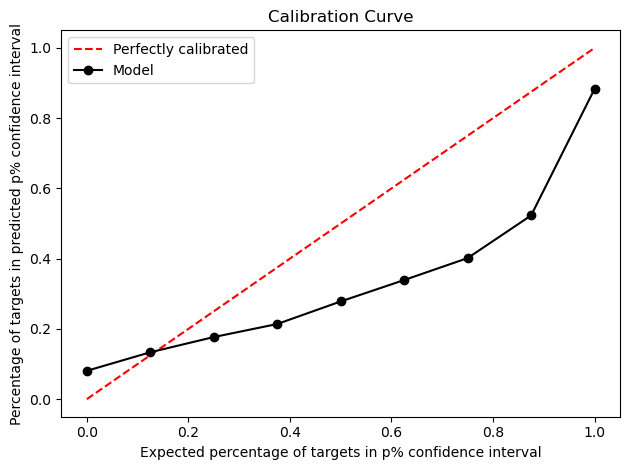

In [12]:
from deep_uncertainty.evaluation.calibration import plot_regression_calibration_curve


plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

In [13]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['scripts'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_3587/1509262161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_3587/1509262161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['scripts'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_3587/1509262161.

In [14]:
nb2_training_results.params

Intercept         0.290050
scripts           0.156681
detailing         0.061958
lagged_scripts   -0.017614
generalphys      -0.008611
specialist        0.023104
dtype: float64

In [15]:
print(mean_squared_error(predictions_summary_frame['mean'], y_test))
print(np.sqrt(mean_squared_error(predictions_summary_frame['mean'], y_test)))

440233.02391347097
663.5005832050722


In [16]:
y_preds = predicted_counts
y_test = y_test['scripts']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)

In [17]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.3748668960583307

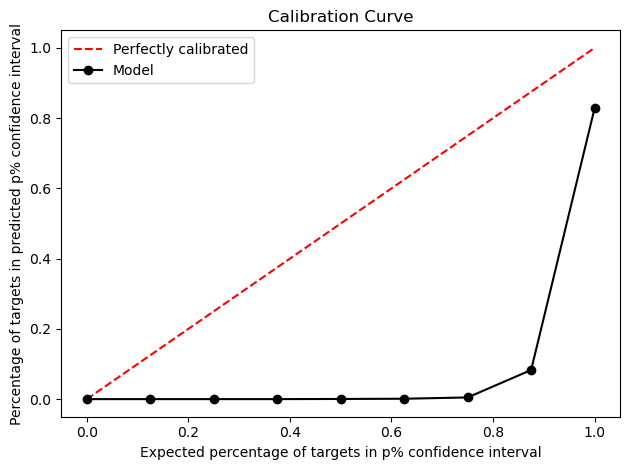

In [18]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)